# Initial Data Reading and Cleaning

In [244]:
import pandas as pd
import numpy as np

df = pd.read_csv('./ingredients_refined.csv')

df = df.drop_duplicates(subset=['ingredient'])

ingredients = np.array(df['ingredient'].str.lower().values)
price = np.array(df['price'].values)
metric = np.array(df['metric'].values)

# Building the amount matrix

In [245]:
import json

with open('./train.json', 'r') as f:
    recipes = json.load(f)

matrix = pd.DataFrame(columns=ingredients, index = [recipe['id'] for recipe in recipes])
matrix.columns = matrix.columns.str.strip()

for recipe in recipes:
    for ingredient in recipe["ingredients"]:
        ingredient = ingredient.strip().lower()
        for column in matrix.columns:
            if ingredient in column:  # Check if ingredient is a substring of the column
                matrix.loc[recipe["id"], column] = 1

matrix = matrix.fillna(0)
matrix.to_csv('./matrix.csv')

/var/folders/l7/ywb8q5r53j33j1lqzbzjyshm0000gn/T/ipykernel_35442/322743879.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = matrix.fillna(0)


# Modeling

# TO ADD

1. Advanced recipes constraint (i.e.) $$ \sum_{i=1}^{|I|} Contains_{i. r}*x_r \geq 7 \ \ \forall r$$

### Set definitions

In [247]:
import gamspy as gp
import numpy as np
import gamspy.math as gpm

cont = gp.Container()
I = cont.addSet('I', records = [ingredients[idx] for idx in range(len(ingredients))], description = 'A set containing all of the valid ingredients')
R = cont.addSet('R', records = [recipe['id'] for recipe in recipes], description= 'A set containing all of the recipes that can be made')

### Parameter Definitions

In [248]:
C = cont.addParameter('C', domain=[I], description="Cost per unit of each of the ingredients", records = price)
A = cont.addParameter('A', domain=[R, I], description="Amount of ingredient i required in recipe r", records = np.array(matrix))
B = cont.addParameter('B', description="Budget to purchase ingredients", records=400)
lam = cont.addParameter('lam', description="Trade off parameter used to weight the regularizer", records = .01)

### Variable Definitions

In [249]:
z = cont.addVariable('z', "integer", domain=[I], description="Amount of ingredient i purchased")
x = cont.addVariable('x', "binary", domain=[R], description="Indicator variable to make recipe r")
l = cont.addVariable('l', "free", domain=[I], description="Leftover ingredients after all recipes are made")

### Equations

In [250]:
budget = cont.addEquation('budget', 'regular',
                        description="Constrains the total money spent on ingredients to be within the budget")
budget[:] = gp.Sum(I, C[I] * z[I]) <= B

ingredient_amounts = cont.addEquation('ingredient_amounts', 'regular', domain=[I],
                              description="Ensures enough ingredients are purchased to satisfy the selected recipes")
ingredient_amounts[I] = gp.Sum(R, A[R, I] * x[R]) <= z[I]

waste = cont.addEquation('waste', 'regular', domain=[I],
                          description="Sets the leftover variable equal to the amount of unused ingredients")
waste[I] = l[I] == z[I] -  gp.Sum(R, A[R, I] * x[R])

tot_recipes = cont.addEquation('tot_recipes', description="Ensures enough recipes for a weeks worth of dinner can be made")
tot_recipes[:] = gp.Sum(R, x[R]) >= 7

z.lo[:]= 0
l.lo[:] = 0

In [251]:
objective = gp.Sum(R, x[R]) - lam * gp.Sum(I, l[I])

recipe_optimization = cont.addModel(
    name='recipe_optimization',
    problem=gp.Problem.MIP,
    equations=cont.getEquations(),
    sense=gp.Sense.MAX,
    objective=objective
)

In [252]:
recipe_optimization.solve(solver = 'cplex')
df = z.records
print(f"Amount of ingredients to purchase: {len(df[df['level'] > 0])}")
print(f"Recipes to make {x.records[x.records['level'] > 0]}")

Amount of ingredients to purchase: 51
Recipes to make          R  level  marginal  lower  upper  scale
19   44812    1.0       1.0    0.0    1.0    1.0
24   33071    1.0       1.0    0.0    1.0    1.0
31     793    1.0       1.0    0.0    1.0    1.0
33    7406    1.0       1.0    0.0    1.0    1.0
34    7473    1.0       1.0    0.0    1.0    1.0
39   20665    1.0       1.0    0.0    1.0    1.0
42   27869    1.0       1.0    0.0    1.0    1.0
43   44776    1.0       1.0    0.0    1.0    1.0
46   27165    1.0       1.0    0.0    1.0    1.0
49   29853    1.0       1.0    0.0    1.0    1.0
54   21467    1.0       1.0    0.0    1.0    1.0
55   20919    1.0       1.0    0.0    1.0    1.0
60   27008    1.0       1.0    0.0    1.0    1.0
61   31867    1.0       1.0    0.0    1.0    1.0
65    7023    1.0       1.0    0.0    1.0    1.0
66    7783    1.0       1.0    0.0    1.0    1.0
67    2472    1.0       1.0    0.0    1.0    1.0
68   45193    1.0       1.0    0.0    1.0    1.0
77    9010    1

# Sensitivity Analysis

## lambda sensitivity

## budget sensitivity

/Users/liamsoule/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liamsoule/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


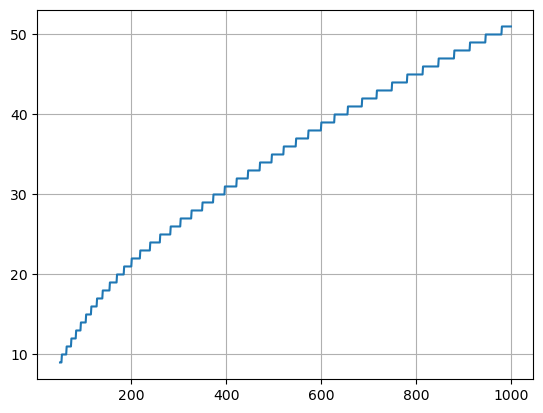

In [253]:
import seaborn as sns
import matplotlib.pyplot as plt 

amount_recipes = []
budget = []
loss = []

for num in range(50, 1000):
    B.setRecords(num)
    recipe_optimization.solve(solver = 'cplex')
    df = x.records
    number_recipes = len(df[df['level'] > 0])
    loss.append(l.records['level'].sum())
    budget.append(num)
    amount_recipes.append(number_recipes)
    num += 50

import seaborn as sns

sns.lineplot(x = budget, y = amount_recipes)
plt.grid()


/Users/liamsoule/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liamsoule/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


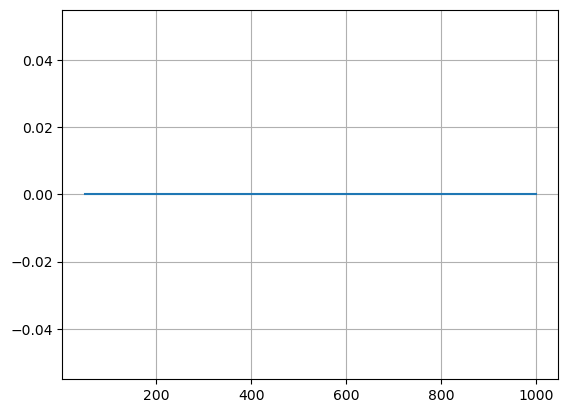

In [254]:
sns.lineplot(x = budget, y = loss)
plt.grid()